In [9]:
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi
import nibabel as nib
import nrrd
import ants
import numpy as np
import os
import logging
from pathlib import Path

In [10]:
avgt_file = '/Users/mahdi/stage-2022-mahdi/src/AVGT.nii.gz'
res_avgt_mm = 70 / 1e3
avgt_offset = np.array([-5.675, -8.79448, -8.450335, 0])

In [11]:
def select_resolution(res):
    mca = MouseConnectivityApi()
    if res==100 : res = mca.VOXEL_RESOLUTION_100_MICRONS
    elif res==50 : res = mca.VOXEL_RESOLUTION_50_MICRONS
    elif res==25 : res = mca.VOXEL_RESOLUTION_25_MICRONS
    return res


def download_allen_projection_density(res, id, directory="."):
    
    directory = Path(directory)
    directory.absolute()
    directory.mkdir(exist_ok=True, parents=True)

    # Preparing the filenames
    nrrd_file = directory / f"{id}_projection_density.nrrd"
    nifti_file = directory / f"{id}_projection_density.nii.gz"
    
    # Downloading the projection density
    mca = MouseConnectivityApi()
    res = select_resolution(res)
    mca.download_projection_density(
        nrrd_file,
        experiment_id=id, 
        resolution=res
        )

    # Loading the nrrd file
    vol, header = nrrd.read(nrrd_file)

    # Preparing the affine to align the volume in the RAS+
    r_mm = res / 1e3
    affine = np.array([[0, 0, r_mm, 0],
                       [-r_mm, 0, 0, 0],
                       [0, -r_mm, 0, 0],
                       [0, 0, 0, 1]])

    # Saving the volume (nifti)
    img = nib.Nifti1Image(vol, affine)
    nib.save(img, nifti_file)

    # Deleting the nrrd file
    os.remove(nrrd_file)

    return nifti_file, id

In [12]:
def transform_manually_to_ras(allen_volume, directory="."):
    
    directory = Path(directory)
    directory.absolute()
    directory.mkdir(exist_ok=True, parents=True)

    # Preparing the filename
    projection_ras_file = directory / f"allen_volume_manualRAS.nii.gz"

    # Loading the volume
    vol = nib.load(allen_volume).get_fdata()
    
    # Manually transforming the volume
    vol_ras = np.moveaxis(vol, (0,1,2), (1,2,0))
    vol_ras = np.flip(vol_ras, axis=2)
    vol_ras = np.flip(vol_ras, axis=1)
    
    # Scaling to AVGT resolution
    affine = np.eye(4) * res_avgt_mm

    # Saving the volume (nifti)
    img_ras = nib.Nifti1Image(vol_ras, affine)
    nib.save(img_ras, projection_ras_file)

    # Deleting the old file
    os.remove(allen_volume)

    return projection_ras_file

In [13]:
def align_volume_on_avgt(res,allen_volume, id, directory="."):
    
    directory = Path(directory)
    directory.absolute()
    directory.mkdir(exist_ok=True, parents=True)

    # Preparing the filename
    aligned_volume_file = directory / f"{id}_projection_density_{res}.nii.gz"
    
    # Loading the AVGT (fixed reference volume)
    avgt = nib.load(avgt_file)
    ref_vol = avgt.get_fdata()

    # Loading the Allen volume (moving allen volume)
    allen = nib.load(allen_volume)
    allen_vol = allen.get_fdata()

    # Converting to float array
    allen_vol = allen_vol.astype(float)
    ref_vol = ref_vol.astype(float)

    # Creating ANTsPy images
    fixed = ants.from_numpy( ref_vol ).resample_image((164, 212, 158),1,0)
    moving = ants.from_numpy( allen_vol ).resample_image((164, 212, 158),1,0)

    # Using the transformation list calculated with the allen template
    transformations = [f'/Users/mahdi/stage-2022-mahdi/src/transformations/allen2avgt_{res}.nii.gz',
                       f'/Users/mahdi/stage-2022-mahdi/src/transformations/allen2avgtAffine_{res}.mat']
    interpolation = 'bSpline'#'nearestNeighbor'
    
    # Applying the transformation
    warped_moving = ants.apply_transforms(fixed=fixed, moving=moving, 
                                          transformlist=transformations,
                                          interpolator=interpolation)
    
    fixed.plot_ortho_double(warped_moving)
    
    # Placing the volume at the avgt origin in mi-brain
    affine = allen.affine
    affine_offset = affine.copy()
    affine_offset[:,3] = affine_offset[:,3] + avgt_offset

    # Changing the registrate volume to numpy array
    warped_vol = warped_moving.numpy()

    # Saving the volume (nifti)
    img = nib.Nifti1Image(warped_vol, affine_offset)
    nib.save(img, aligned_volume_file)

    # Deleting the old file
    os.remove(allen_volume)

    return aligned_volume_file

2022-05-04 14:56:24,783 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/288169135?image=projection_density&resolution=100


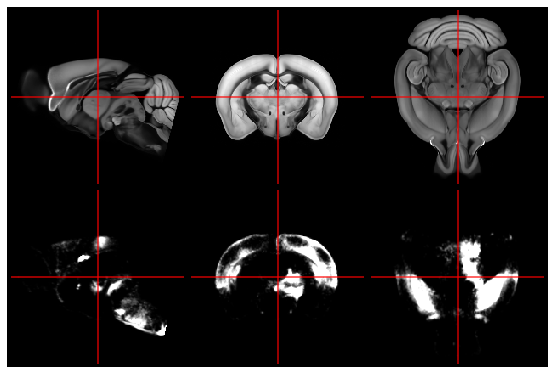

In [14]:
directory = "/Users/mahdi/stage-2022-mahdi/src"

rez = 100

allen_nifti, id = download_allen_projection_density(res=rez, id=288169135)
allen_manualRAS = transform_manually_to_ras(allen_volume=allen_nifti)
allen_MIbrain = align_volume_on_avgt(res=rez, allen_volume=allen_manualRAS, id=id)